In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scipy.integrate as integrate
import pytorch_soo

# Collapser implementation

In [162]:
def _interpolate_between_samples(
        t_grid: torch.Tensor,
        idx_samples: torch.Tensor,
        x_samples: torch.Tensor,
):
    """
    Returns a linear interpolation between the points x_samples at the grid points t_grid[idx_samples].

    :param t_grid: Grid of times.
    :param idx_samples: Indices of times that x values are samples from.
    :param x_samples: Samples at times. Shape must match idx_samples.
    :return: Interpolated x values, should match the shape of t_grid.
    """
    x_interpolated = torch.tile(input=x_samples[0, :], dims=(t_grid.shape[0], 1))
    for j, (i1, i2) in enumerate(zip(idx_samples[:-1], idx_samples[1:])):
        aa = x_samples[j, :] + (x_samples[j + 1, :] - x_samples[j, :]) * ((
                    t_grid[i1 + 1:i2 + 1] - t_grid[i1]) / (t_grid[i2] - t_grid[i1])).reshape((-1, 1))
        x_interpolated[i1 + 1: i2 + 1, :] = aa
    x_interpolated[idx_samples[-1] + 1:, :] = x_samples[-1, :]
    return x_interpolated


def collapse_to_solution(
    rhs,
    h,
    t_start,
    t_end,
    idx_samples,
    x_samples,
    dim,
    transformation_x2z=None,
    N_iter=5000,
    eta=1e-3,
    initialize_by_interpolation=True,
    logging_freq_scalars=1,
    logging_freq_grids=10,
    show_progress=False,
    get_optimizer_from_params=None,
):
    # Get the number of grid points
    t_grid = torch.arange(t_start, t_end, h)
    n_grid = t_grid.shape[0]

    # If the inputs are not torch tensors, try and make tensors from them.
    assert x_samples.shape[1] == dim
    assert idx_samples.shape[0] == x_samples.shape[0]  # FIXME - will need to modify in the case of vector x with partial observations
    if not isinstance(idx_samples, torch.Tensor):
        idx_samples = torch.tensor(idx_samples, requires_grad=False)
    if not isinstance(x_samples, torch.Tensor):
        x_samples = torch.tensor(x_samples, requires_grad=False)
    eta = torch.tensor(eta)
    # FIXME - check that idx_samples are sorted. Else do dual-sort of idx_samples and x_samples

    # I believe this is necessary to avoid errors if we ever move the tensors to the gpu
    # (and to avoid a deprecation warning even if they are on the cpu).
    rhs = torch.vmap(rhs, in_dims=(0, 0), out_dims=0)
    #rhs = torch.compile(rhs)

    if transformation_x2z is None:
        # The default option transforms the problem into gradient-space plus a constant.
        transformation_x2z = torch.zeros((n_grid, n_grid), dtype=torch.float64)
        transformation_x2z[0, 0] = 1.0  # z_0 = x(t_0)
        for i in range(1, n_grid):
            # z_i = x(t_i) - x(t_{i-1}) for i > 0
            transformation_x2z[i, i] = 1.0
            transformation_x2z[i, i - 1] = -1.0

        # We know the inverse in this case
        transformation_z2x = torch.zeros_like(transformation_x2z)
        for i in range(0, n_grid):
            transformation_z2x[i, :i+1] = 1.0
        
        # # Default transformation is the identity
        # transformation_x2z = torch.eye(n_grid, dtype=torch.float64)
    else:
        if not isinstance(transformation_x2z, torch.Tensor):
            transformation_x2z = torch.tensor(transformation_x2z)
        # Invert the transformation matrix. We will need this repeatedly later.
        if torch.linalg.det(transformation_x2z).item() < 1e-4:
            error_msg = f'Transformation matrix from [x(t_i)] to [z_i] has a small determinant.'
            raise ValueError(error_msg)
        transformation_z2x = torch.linalg.inv(transformation_x2z)
    print(transformation_z2x[:5, :5])
    print(transformation_z2x[-5:, -5:])

    # # Default loss-weighting schedule
    # if get_w_ODE is None:
    #     def get_w_ODE(it, n_iterations):
    #         if it < 0.1 * n_iterations:
    #             # First 10% of steps: optimize mainly for fitting the samples
    #             w_ode = 1e-2
    #         elif it >= 0.9 * n_iterations:
    #             # Final 90% of steps: optimize mainly for satisfying the ODE
    #             w_ode = 1.0
    #         else:
    #             # Linear ramp-up of w_ODE in between these iterations
    #             w_ode = 1e-2 + (1 - 1e-2) * (it - 0.1 * n_iterations) / (0.8 * n_iterations)
    #         return w_ode
    
    # Initialize the solution grid.
    # FIXME - do I need to change this in the case of partial observations?
    #         e.g. what if I get (x, xdot) at point i, but only x at point i+1?
    # I don't believe there is any benefit to using random initialization, since this problem does not
    # have the same requirement for symmetry-breaking that exists with the hidden neurons of a neural network.
    if initialize_by_interpolation:
        # FIXME - need to make _interpolate_between_samples work for partial observations.
        x_interpolated = _interpolate_between_samples(t_grid, idx_samples, x_samples)
        z_solution_grid = (transformation_x2z @ x_interpolated).detach().clone().to(torch.float64).requires_grad_(True)
    else:
        z_solution_grid = torch.zeros((n_grid, dim), dtype=torch.float64, requires_grad=True)

    # Initialize the optimizer.
    # This problem seems to benefit from using a second-order optimizer (which LBFGS is), and I believe that
    # is due to the Hessian of loss_ODE (see below for definition) having a very large condition number.
    if get_optimizer_from_params is None:
        optimizer = torch.optim.LBFGS(lr=1, history_size=5, params=[z_solution_grid], max_iter=5, line_search_fn='strong_wolfe')
        optimizer_data = torch.optim.LBFGS(lr=1e-1, history_size=2, params=[z_solution_grid], max_iter=2, line_search_fn='strong_wolfe')
    else:
        optimizer = get_optimizer_from_params([z_solution_grid])
    # optimizer_ODE = torch.optim.LBFGS(lr=1e-2, history_size=10, params=[z_solution_grid], max_iter=3)
    # optimizer_data = torch.optim.LBFGS(lr=1e-2, history_size=10, params=[z_solution_grid], max_iter=3)

    # Loss function definitions

    # The loss for the optimization problem has two parts:
    # loss_data measures the l2 error of the data relative to our current solution x(t_0), x(t_1), ..., x(t_{N-1})
    # loss_ODE measures the l2 norm of the local violation of the ODE.
    # Our aim is to bring loss_ODE to zero while keeping loss_data as small as possible.

    # Note that loss_data is normalized by the number of samples.
    # FIXME - add an option to weight data points (and dimensions within points)
    # FIXME - does this work in multiple dimensions (genuinely unsure)
    def loss_data(z):
        #x = transformation_z2x @ z
        x = torch.cumsum(z, dim=0)
        x_at_sample_points = x[idx_samples, :]
        error_of_samples = (x_at_sample_points - x_samples)
        loss_val = 0.5 * torch.mean(error_of_samples ** 2)
        return loss_val

    # Note that this loss is a sum over only the interior points, 0, 2, ..., N-2.
    # This is because we do not have sufficient data to compute the forward derivative at N-1.
    # This should be consistent with your intuition: if we simply demand that loss_ODE = 0,
    # we would have d*(N-1) equations in d*N unknowns.
    # This would (typically) have a d-dimensional space of solutions,
    # which is what we should expect for a 1st order, d-dimensional ODE.
    def loss_ODE(z):
        #x = transformation_z2x @ z
        x = torch.cumsum(z, dim=0)
        first_deriv = h**(-1) * (x[1:, :] - x[:-1, :])
        rhs_val = rhs(0.5*(x[1:, :] + x[:-1, :]), 0.5*(t_grid[1:] + t_grid[:-1]))
        # Note the factor of h. This cancels out the implicit factor of n_grid from the sum.
        # Alternatively, think of this loss as the (approximation to) the integral of the l2-violation of the ODE.
        loss_val = 0.5 * h * torch.sum((first_deriv - rhs_val) ** 2)
        return loss_val

    # Optimization takes place below here

    # Initialize logging history
    log_scalars = []
    log_grids = []

    success_flag = True  # Set to false if an error condition is encountered
    failure_reason = None  # Should be set if success_flag gets set to False
    iterations = tqdm(range(N_iter)) if show_progress else range(N_iter)
    w_ODE = torch.tensor(1.0)
    for iteration in iterations:
        if iteration == 0:
            # First iteration is a special case.
            # Want to take a single, regular SGD step to get away from the point of zero-gradient of L_data
            loss_ODE_torch = loss_ODE(z_solution_grid)
            loss_data_torch = loss_data(z_solution_grid)
            loss_ODE_torch.backward()
            grad_ODE = z_solution_grid.grad
            with torch.no_grad():
                #eta = 0.1 * h**3
                eta_limited = torch.tensor(0.1*h**3)  # FIXME - clean up
                z_solution_grid.sub_((0.1*h**3)*grad_ODE)
            z_solution_grid.grad = None  # Clear this for later iterations
        else:
            loss_data_torch = loss_data(z_solution_grid)
            # loss_data_torch.backward(retain_graph=True)
            # grad_data = z_solution_grid.grad
            # z_solution_grid.grad = None
            
            loss_ODE_torch = loss_ODE(z_solution_grid)
            # loss_ODE_torch.backward(retain_graph=True)
            # grad_ODE = z_solution_grid.grad
            # z_solution_grid.grad=None

            # with torch.no_grad():
            #     # w_ODE_ratio = torch.linalg.norm(grad_data, ord=2)/torch.sqrt(torch.linalg.norm(grad_data, ord=2)**2 + torch.linalg.norm(grad_ODE, ord=2)**2)
            #     # w_ODE = 0.9*w_ODE + 0.1*w_ODE_ratio
            #     w_ODE1 = torch.abs(torch.dot(grad_data.flatten(), grad_ODE.flatten())/(torch.linalg.norm(grad_data, ord=2)*torch.linalg.norm(grad_ODE, ord=2)))
            #     w_ODE = 0.8*w_ODE + 0.2*w_ODE1
            #     print(w_ODE)
            
            #loss_total = (1.0 - w_ODE)*loss_data_torch + w_ODE*loss_ODE_torch
            
            # Step in the direction of decreasing ODE loss
            # eta_limited = torch.min(eta, 0.1*loss_ODE_torch/torch.linalg.norm(grad_ODE, ord=2)**2)
            # with torch.no_grad():
            #     z_solution_grid.sub_(eta_limited*grad_ODE)
            # Step in the direction of decreasing data loss, removing the component parallel to the gradient of ODE loss.
            # This projection prevents the data gradient 'fighting' against the ODE gradient.
            # with torch.no_grad():
            #     grad_projected = (grad_data - grad_ODE*(torch.dot(grad_ODE.flatten(), grad_data.flatten())/torch.linalg.norm(grad_ODE, ord=2)**2))
            #     z_solution_grid.sub_(eta_limited*grad_projected)
            # optimizer.zero_grad()
            # loss_ODE_torch.backward()
            def closure():
                optimizer.zero_grad()
                output = loss_ODE(z_solution_grid)
                output.backward()
                return output
            optimizer.step(closure)

            loss_ODE_last = loss_ODE_torch.clone()
            loss_data_last = loss_data_torch.clone()
            def closure2():
                optimizer_data.zero_grad()
                l_data = loss_data(z_solution_grid)
                l_data.backward()  # Compute unconstrained gradient of L_data
                grad_data = z_solution_grid.grad
                z_solution_grid.grad = None
                l_ODE = loss_ODE(z_solution_grid)
                l_ODE.backward()  # Compute unconstrained gradient of L_ODE
                grad_ODE = z_solution_grid.grad
                # Project the gradient of L_data onto the tangent space of the contour of L_ODE that we are currently on.
                grad_projected = (grad_data - grad_ODE*(torch.dot(grad_ODE.flatten(), grad_data.flatten())/torch.linalg.norm(grad_ODE, ord=2)**2))
                z_solution_grid.grad = grad_projected

                output = torch.max(l_data, (loss_data_last/loss_ODE_last)*l_ODE/1.5)
                loss_ODE_last.set_(l_ODE)
                loss_data_last.set_(l_data)
                return output
            optimizer_data.step(closure2)


        # In many of my early experiments, the solution became NaN due to numerical instability.
        # If this happens, it is useful to fail at this point.
        # It is also helpful to know which iteration this happened at.
        if z_solution_grid.isnan().any().item():
            error_msg = f'NaNs appeared in solution after iteration {iteration}'
            failure_reason = error_msg
            success_flag = False

        if iteration % logging_freq_scalars == 0:
            log_scalars.append({
                'iteration': iteration,
                #'w_ODE': w_ODE,
                'loss_data': loss_data_torch.detach().numpy(),
                'loss_ODE': loss_ODE_torch.detach().numpy(),
                'eta_limited': eta_limited.detach().numpy(),
                #'loss_total': loss_val_total,
            })

        if iteration % logging_freq_grids == 0:
            log_grids.append({
                'iteration': iteration,
                'z_grid': z_solution_grid.detach().numpy(),
                'x_grid': (transformation_z2x @ z_solution_grid).detach().numpy(),
            })

        # Break out of the loop if we have encountered a failure reason
        if success_flag == False:
            break

    # Convert the solution back to x-space.
    # This may already be stored in the logs (if logging_freq_grids divides N_iter).
    x_solution_grid = (transformation_z2x @ z_solution_grid).detach().numpy()

    return {
        'success': success_flag,
        'failure_reason': failure_reason,
        'x_solution_grid': x_solution_grid,
        'log_scalars': log_scalars,
        'log_grids': log_grids,
    }

# Example 1: $\dot{x} = x$

In [37]:
def get_w_ODE(it, N_iterations):
    return 1.0

# def get_optim(params):
#     return torch.optim.SGD(lr=1e-3, params=params)

In [38]:
def f_rhs(x, t):
    return x

In [39]:
sigma = 0.1
n_samples = 20

t_start = 0.0
t_end = 1.0
h = 1e-3
t_grid = np.arange(t_start, t_end, h)
x_grid = np.exp(t_grid).reshape((-1, 1))
n_grid = t_grid.shape[0]

rng = np.random.RandomState(123)
idx_samples = rng.choice(n_grid, size=n_samples, replace=False)
idx_samples = np.sort(idx_samples)
x_samples = x_grid[idx_samples, :] + rng.normal(size=(n_samples, 1), scale=sigma)
t_samples = t_grid[idx_samples]
del rng

In [40]:
collapser_results = collapse_to_solution(
    f_rhs,
    h=h,
    t_start=0.0,
    t_end=1.0,
    idx_samples=idx_samples,
    x_samples=x_samples,
    dim=1,
    N_iter=200,
    eta=1e-1,
    #get_w_ODE=get_w_ODE,
    #get_optimizer_from_params=get_optim,
    show_progress=True,
)

  0%|          | 0/200 [00:00<?, ?it/s]

C


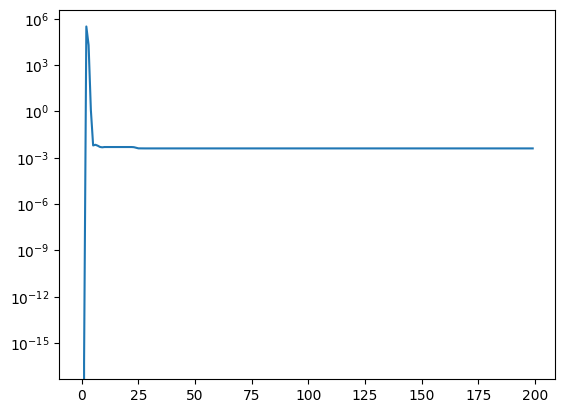

In [41]:
plt.plot(
    [collapser_results['log_scalars'][i]['loss_data'] for i in range(len(collapser_results['log_scalars']))],
    ls='-', marker='none', color='tab:blue'
)
plt.yscale('log')

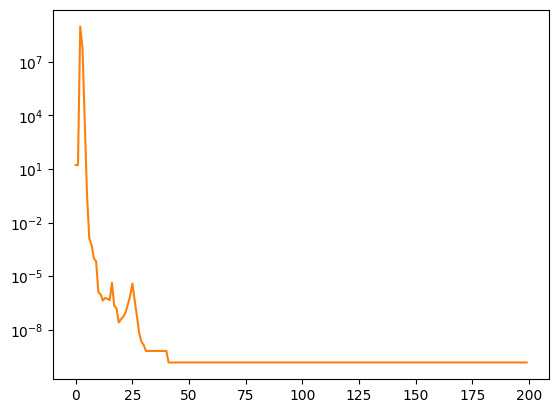

In [42]:
plt.plot(
    [collapser_results['log_scalars'][i]['loss_ODE'] for i in range(len(collapser_results['log_scalars']))],
    ls='-', marker='none', color='tab:orange'
)
plt.yscale('log')

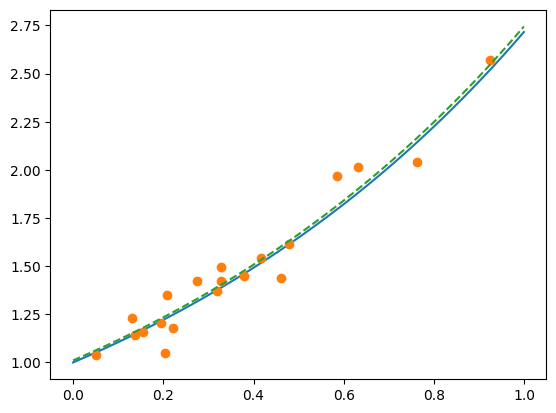

In [43]:
fig, ax = plt.subplots()

ax.plot(t_grid, x_grid, ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples, ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'], ls='--', marker='none', color='tab:green')

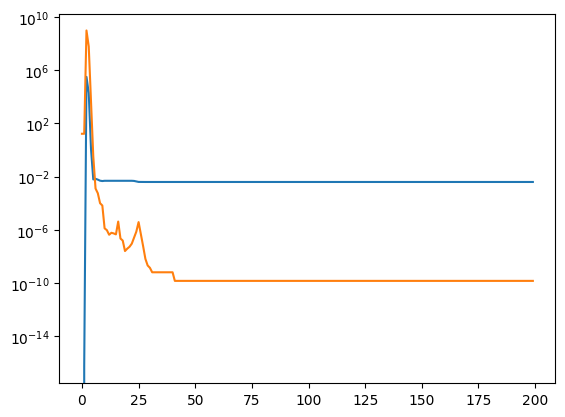

In [44]:
fig, ax = plt.subplots()

ax.plot([collapser_results['log_scalars'][i]['loss_data'] for i in range(len(collapser_results['log_scalars']))])
ax.plot([collapser_results['log_scalars'][i]['loss_ODE'] for i in range(len(collapser_results['log_scalars']))])
#ax.set_ylim(0.0, 1.0)
ax.set_yscale('log')

# Example 2: $\dot{x} = -(x-1)x(x+1)$

  0%|          | 0/200 [00:00<?, ?it/s]

C
tensor(5.2852e-11, dtype=torch.float64)
tensor(0.9000, dtype=torch.float64)
tensor(2.0434e-18, dtype=torch.float64)
tensor(0.8100, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64)
tensor(0.8290, dtype=torch.float64)
tensor(0.8823, dtype=torch.float64)
tensor(0.8343, dtype=torch.float64)
tensor(0.9886, dtype=torch.float64)
tensor(0.8498, dtype=torch.float64)
tensor(0.9591, dtype=torch.float64)
tensor(0.8607, dtype=torch.float64)
tensor(0.9747, dtype=torch.float64)
tensor(0.8721, dtype=torch.float64)
tensor(0.9697, dtype=torch.float64)
tensor(0.8819, dtype=torch.float64)
tensor(0.9721, dtype=torch.float64)
tensor(0.8909, dtype=torch.float64)
tensor(0.9715, dtype=torch.float64)
tensor(0.8990, dtype=torch.float64)
tensor(0.9721, dtype=torch.float64)
tensor(0.9063, dtype=torch.float64)
tensor(0.9721, dtype=torch.float64)
tensor(0.9129, dtype=torch.float64)
tensor(0.9723, dtype=torch.float64)
tensor(0.9188, dtype=torch.float64)
tensor(0.9725, dtype=torch.float64)
tensor(0.9242, dty

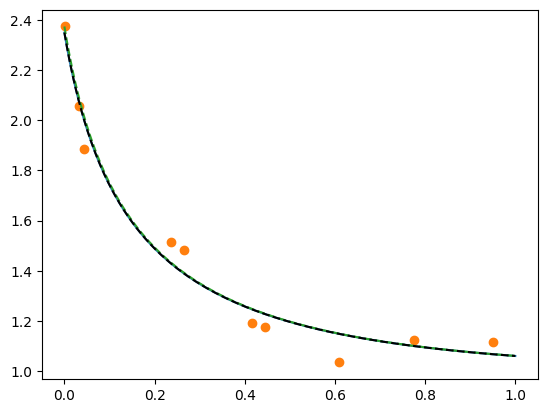

In [57]:
# Example for xdot = -(x-1)*x*(x+1)

def f_rhs(x, t):
    return -(x - 1)*x*(x + 1)


def soln(t):
    return 1/np.sqrt(1 - np.exp(-2*(t+0.1)))

sigma = 0.1
n_samples = 10

t_start = 0.0
t_end = 1.0
h = 1e-4
t_grid = np.arange(t_start, t_end, h)
x_grid = soln(t_grid).reshape((-1, 1))
n_grid = t_grid.shape[0]


# Get numerical solution
ode_integrator = integrate.ode(f = lambda t, y:f_rhs(y, t))
ode_integrator.set_initial_value(np.array([1 / np.sqrt(1 - np.exp(-0.2))]))
x_numeric = np.zeros_like(t_grid)
x_numeric[0] = ode_integrator.y[0]
for i, t in enumerate(t_grid[1:]):
    x_numeric[i+1] = ode_integrator.integrate(t)[0]

rng = np.random.RandomState(123)
idx_samples = rng.choice(n_grid, size=n_samples, replace=False)
idx_samples = np.sort(idx_samples)
x_samples = x_grid[idx_samples, :] + rng.normal(size=(n_samples, 1), scale=sigma)
t_samples = t_grid[idx_samples]
del rng

collapser_results = collapse_to_solution(
    f_rhs,
    h=h,
    t_start=0.0,
    t_end=1.0,
    N_iter=200,
    idx_samples=idx_samples,
    x_samples=x_samples,
    dim=1,
    show_progress=True,
)

fig, ax = plt.subplots()

ax.plot(t_grid, x_grid, ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples, ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'], ls='--', marker='none', color='tab:green')
ax.plot(t_grid, x_numeric, ls='--', marker='none', color='black')

plt.show()

# Example 1.5: Trivial 2D example

Two independent versions of $\dot{x} = x$

  0%|          | 0/200 [00:00<?, ?it/s]

C


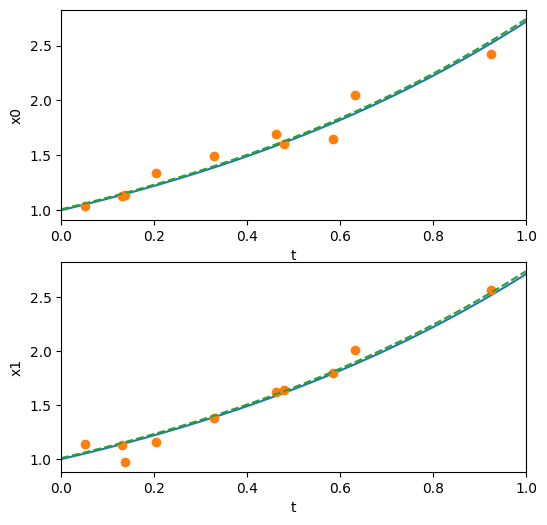

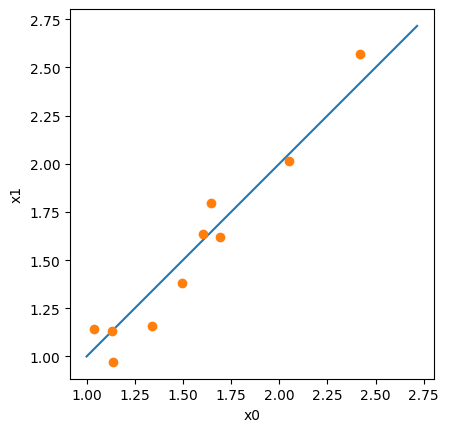

In [65]:
# Example for x0dot = x0, x1dot = x1

def f_rhs(x, t):
    return x

sigma = 0.1
n_samples = 10

t_start = 0.0
t_end = 1.0
h = 1e-3
t_grid = np.arange(t_start, t_end, h)
n_grid = t_grid.shape[0]
x_grid = np.zeros((n_grid, 2))
x_grid[:, 0] = np.exp(t_grid)
x_grid[:, 1] = np.exp(t_grid)

rng = np.random.RandomState(123)
idx_samples = rng.choice(n_grid, size=n_samples, replace=False)
idx_samples = np.sort(idx_samples)
x_samples = x_grid[idx_samples, :] + rng.normal(size=(n_samples, 2), scale=sigma)
t_samples = t_grid[idx_samples]
del rng

collapser_results = collapse_to_solution(
    f_rhs,
    h=h,
    t_start=0.0,
    t_end=1.0,
    N_iter=200,
    idx_samples=idx_samples,
    x_samples=x_samples,
    dim=2,
    show_progress=True,
)

fig, axs = plt.subplots(nrows=2, figsize=(6, 6))

ax = axs[0]
ax.plot(t_grid, x_grid[:, 0], ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples[:, 0], ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'][:, 0], ls='--', marker='none', color='tab:green')
ax.set_xlim(t_start, t_end)
ax.set_xlabel('t')
ax.set_ylabel('x0')

ax = axs[1]
ax.plot(t_grid, x_grid[:, 1], ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples[:, 1], ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'][:, 1], ls='--', marker='none', color='tab:green')
ax.set_xlim(t_start, t_end)
ax.set_xlabel('t')
ax.set_ylabel('x1')

plt.show()

fig, ax = plt.subplots()
ax.set_aspect(1.0)
ax.plot(x_grid[:, 0], x_grid[:, 1])
ax.plot(x_samples[:, 0], x_samples[:, 1], ls='none', marker='o', color='tab:orange')
ax.set_xlabel('x0')
ax.set_ylabel('x1')

plt.show()

# Examples 3: Lotka-Volterra equations

$$
\dot{x} = \alpha x - \beta x y 
$$
$$
\dot{y} = -\gamma y + \delta x y
$$

Will use parameter values taken from Wikipedia: $\alpha = 2/3, \beta = 4/3, \gamma = \delta = 1$

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]], dtype=torch.float64)
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]], dtype=torch.float64)


  0%|          | 0/2000 [00:00<?, ?it/s]

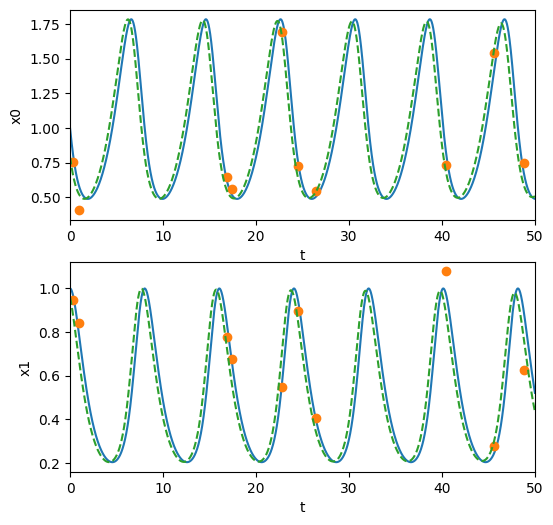

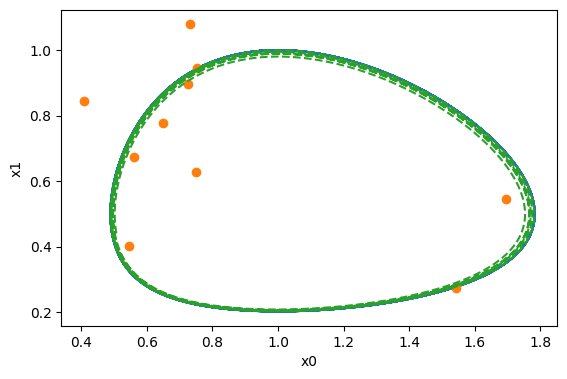

In [163]:
# Example for:
# x0dot = alpha * x0 - beta * x0*x1
# x1dot = -gamma * x1 + delta * x0*x1

alpha = 2.0/3.0
beta = 4.0/3.0
gamma = 1.0
delta = 1.0

arr1 = torch.tensor([alpha, -gamma])
arr2 = torch.tensor([-beta, delta])
def f_rhs(x, t):
    return arr1*x + arr2*x[0]*x[1]

# Needed to explicitly make a numpy version to get rid of a deprecation warning.
def f_np(x, t):
    return arr1.numpy()*x + arr2.numpy()*x[0]*x[1]

sigma = 0.1
n_samples = 10

t_start = 0.0
t_end = 50.0
h = 1e-2
t_grid = np.arange(t_start, t_end, h)
#x_grid = soln(t_grid).reshape((-1, 1))
n_grid = t_grid.shape[0]


# Get numerical solution
ode_integrator = integrate.ode(f = lambda t, y:f_np(y, t))
ode_integrator.set_initial_value(np.array([1.0, 1.0]))
x_numeric = np.zeros((t_grid.shape[0], 2))
x_numeric[0, :] = ode_integrator.y
for i, t in enumerate(t_grid[1:]):
    x_numeric[i+1, :] = ode_integrator.integrate(t)

rng = np.random.RandomState(123)
idx_samples = rng.choice(n_grid, size=n_samples, replace=False)
idx_samples = np.sort(idx_samples)
x_samples = x_numeric[idx_samples, :] + rng.normal(size=(n_samples, 2), scale=sigma)
t_samples = t_grid[idx_samples]
del rng

collapser_results = collapse_to_solution(
    f_rhs,
    h=h,
    t_start=0.0,
    t_end=50.0,
    N_iter=2000,
    idx_samples=idx_samples,
    x_samples=x_samples,
    dim=2,
    eta=1e-5,
    show_progress=True,
)

fig, axs = plt.subplots(nrows=2, figsize=(6, 6))

ax = axs[0]
ax.plot(t_grid, x_numeric[:, 0], ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples[:, 0], ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'][:, 0], ls='--', marker='none', color='tab:green')
ax.set_xlim(t_start, t_end)
ax.set_xlabel('t')
ax.set_ylabel('x0')

ax = axs[1]
ax.plot(t_grid, x_numeric[:, 1], ls='-', marker='none', color='tab:blue')
ax.plot(t_samples, x_samples[:, 1], ls='none', marker='o', color='tab:orange')
ax.plot(t_grid, collapser_results['x_solution_grid'][:, 1], ls='--', marker='none', color='tab:green')
ax.set_xlim(t_start, t_end)
ax.set_xlabel('t')
ax.set_ylabel('x1')

plt.show()

fig, ax = plt.subplots()
ax.set_aspect(1.0)
ax.plot(x_numeric[:, 0], x_numeric[:, 1])
ax.plot(x_samples[:, 0], x_samples[:, 1], ls='none', marker='o', color='tab:orange')
ax.plot(collapser_results['x_solution_grid'][:, 0], collapser_results['x_solution_grid'][:, 1], ls='--', marker='none', color='tab:green')
ax.set_xlabel('x0')
ax.set_ylabel('x1')

plt.show()

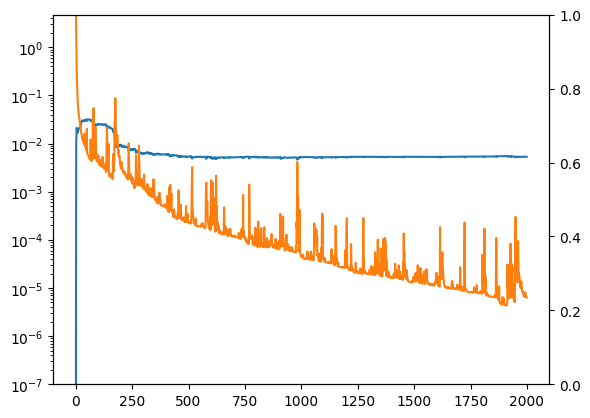

In [164]:
fig, ax = plt.subplots()

ax.plot([collapser_results['log_scalars'][i]['loss_data'] for i in range(len(collapser_results['log_scalars']))])
ax.plot([collapser_results['log_scalars'][i]['loss_ODE'] for i in range(len(collapser_results['log_scalars']))])
ax.set_ylim(bottom=1e-7)
ax.set_yscale('log')
#ax.set_xlim(0, 5)

ax2 = ax.twinx()
# ax2.plot([collapser_results['log_scalars'][i]['eta_limited'] for i in range(len(collapser_results['log_scalars']))])